# 학습 설정

In [1]:
config = {
    'top_k' : 10,
    'epochs' : 30,
    'lr' : 0.001,
    'batch_size' : 256,
    'k' : 64,
    'reg' : 1e-5,
    'neg_samples' : 3,
}

In [ ]:
!pip install python-box
from box import Box
config = Box(config)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.7 MB/s eta 0:00:00


# 데이터 전처리
데이터 셋 다운로드
- https://www.kaggle.com/datasets/rajmehra03/movielens100k

In [ ]:
%cd '/content/drive/MyDrive/RecSys/data/MovieLens-100k'

/content/drive/MyDrive/RecSys/data/MovieLens-100k


In [ ]:
import pandas as pd
import numpy as np
import random
import time
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
data = pd.read_csv('ratings.csv')

In [ ]:
data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [ ]:
user_encoder = {id:idx for idx, id in enumerate(data['userId'].unique())}
user_decoder = {idx:id for id, idx in user_encoder.items()}

item_encoder = {id:idx for idx, id in enumerate(data['movieId'].unique())}
item_decoder = {idx:id for id, idx in item_encoder.items()}

In [ ]:
data['userId'] = data['userId'].apply(lambda x : user_encoder[x])
data['movieId'] = data['movieId'].apply(lambda x : item_encoder[x])

In [ ]:
num_users = len(user_encoder)
num_items = len(item_encoder)
all_items = [i for i in range(num_items)]

user_neg_candidate = {}
for user_id in data['userId'].unique():
  movieId_list = data[data['userId'] == user_id]['movieId'].tolist()
  user_neg_candidate[user_id] = list(set(all_items) - set(movieId_list))

In [ ]:
user_id_list = data['userId'].unique()

train_set_item = []
train_set_user = []
train_set_target = []

test_set_item = []
test_set_user = []
test_set_target = []

for user_id in user_id_list:
  user_df = data[data['userId'] == user_id].sort_values('timestamp')
  movieId_list = user_df['movieId'].tolist()

  train_item = movieId_list[:-1]
  train_user = [user_id] * len(train_item)
  train_target = [1] * len(train_item)

  test_item = [movieId_list[-1]] + np.random.choice(user_neg_candidate[user_id], 99, replace = False).tolist()
  test_user = [user_id] * len(test_item)
  test_target = [1] + [0] * (len(test_item) - 1)

  train_set_item += train_item
  train_set_user += train_user
  train_set_target += train_target

  test_set_item += test_item
  test_set_user += test_user
  test_set_target += test_target

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, set_user, set_item, set_target):
    self.set_user = set_user
    self.set_item = set_item
    self.set_target = set_target

  def __len__(self):
    return len(self.set_user)

  def __getitem__(self, idx) :
    user = self.set_user[idx]
    item = self.set_item[idx]
    target = self.set_target[idx]

    return user, item, target

In [ ]:
train_dataset = CustomDataset(set_user = train_set_user, set_item = train_set_item, set_target = train_set_target)
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True, drop_last = False)

test_dataset = CustomDataset(set_user = test_set_user, set_item = test_set_item, set_target = test_set_target)
test_loader = DataLoader(test_dataset, batch_size = config.batch_size, shuffle = False, drop_last = False)

# 모델

In [ ]:
def metrics(model, test_loader, top_k) :
  model.eval()
  recall = []
  ndcg = []

  with torch.no_grad():
    for user, item, _ in test_loader:
      user = user.to(device)
      item = item.to(device)

      pred = model(user, item)
      _, indices = torch.topk(pred, top_k)
      pred_item = torch.take(item, indices).cpu().numpy().tolist()
      target_item = item[0].item()

      if target_item in pred_item:
        recall.append(1)

        idx = pred_item.index(target_item)
        ndcg.append(np.reciprocal(np.log1p(idx+1)))

      else:
        recall.append(0)
        ndcg.append(0)

  return np.mean(recall), np.mean(ndcg)

In [ ]:
class BPR_loss(nn.Module):
  def __init__(self):
    super(BPR_loss, self).__init__()

  def forward(self, pos, neg) :
    bpr_loss = - torch.mean(torch.log(torch.sigmoid(pos - neg)))
    return bpr_loss

In [ ]:
class MF(nn.Module):
  def __init__(self, num_user, num_item, k) :
    super(MF, self).__init__()
    self.user_emb = nn.Embedding(num_user, k)
    self.item_emb = nn.Embedding(num_item, k)

    self.predict_layer = nn.Sequential(nn.Linear(k, 1, bias = False))
    self._init_weight_()

  def _init_weight_(self):
    nn.init.normal_(self.user_emb.weight, std = 0.01)
    nn.init.normal_(self.item_emb.weight, std = 0.01)
    for l in self.predict_layer:
      nn.init.xavier_uniform_(l.weight)

  def forward(self, user, item):
    user_emb = self.user_emb(user)
    item_emb = self.item_emb(item)

    ouput = self.predict_layer(user_emb * item_emb)
    return ouput.view(-1)

# 학습

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
import copy
mf_model = MF(num_user = num_users, num_item = num_items, k = config.k)

model = copy.deepcopy(mf_model).to(device)
bpr_model = copy.deepcopy(mf_model).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = config.lr)
bpr_optimizer = torch.optim.Adam(bpr_model.parameters(), lr = config.lr)

loss_func = nn.BCELoss()
bpr_loss_func = BPR_loss()

In [ ]:
def get_neg_samples(n, user_id_list):
  neg_samples_user = []
  neg_samples_item = []

  for user in user_id_list :
    u_neg_candidate = user_neg_candidate[user]
    for _ in range(n) :
      neg_samples_item.append(u_neg_candidate[np.random.randint(len(u_neg_candidate))])
      neg_samples_user.append(user)

  return neg_samples_user, neg_samples_item

In [ ]:
non_bpr_model_loss_list = []
non_bpr_model_recall_list = []
non_bpr_model_ndcg_list = []

bpr_model_loss_list = []
bpr_model_recall_list = []
bpr_model_ndcg_list = []

for epoch in tqdm(range(config.epochs)):
  model.train()
  bpr_model.train()

  train_loss = 0.0
  bpr_train_loss = 0.0

  for user, item, target in train_loader :
    neg_user, neg_item = get_neg_samples(n = config.neg_samples, user_id_list = user.numpy().tolist())
    neg_target = [0] * len(neg_item)

    user, item, target = user.to(device), item.to(device), target.to(device).float()
    neg_user, neg_item, neg_target = torch.tensor(neg_user).to(device), torch.tensor(neg_item).to(device), torch.tensor(neg_target).to(device).float()

    all_user = torch.cat([user, torch.tensor(neg_user)])
    all_item = torch.cat([item, torch.tensor(neg_item)])
    all_target = torch.cat([target, torch.tensor(neg_target)])

    optimizer.zero_grad()
    output = model(all_user, all_item)
    loss = loss_func(torch.sigmoid(output), all_target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

    bpr_optimizer.zero_grad()
    output = bpr_model(all_user, all_item)
    pos_output, neg_output = torch.split(output, [len(user), len(neg_user)])
    pos_output = torch.cat([pos_output.view(-1, 1), pos_output.view(-1, 1), pos_output.view(-1, 1)], dim = 1).view(-1)

    loss = bpr_loss_func(pos_output, neg_output)
    loss.backward()
    bpr_optimizer.step()
    bpr_train_loss += loss.item()

  train_loss = train_loss / len(train_loader)
  bpr_train_loss = bpr_train_loss / len(train_loader)

  non_bpr_model_recall, non_bpr_model_ndcg = metrics(model = model, test_loader = test_loader, top_k = config.top_k)
  bpr_model_recall, bpr_model_ndcg = metrics(model = bpr_model, test_loader = test_loader, top_k = config.top_k)

  print(f"[EPOCH : {epoch + 1}, Non-BPR Loss : {train_loss:.4f}, BPR Train Loss: {bpr_train_loss:.4f}]")

  non_bpr_model_loss_list.append(train_loss)
  non_bpr_model_recall_list.append(non_bpr_model_recall)
  non_bpr_model_ndcg_list.append(non_bpr_model_ndcg)

  bpr_model_loss_list.append(bpr_train_loss)
  bpr_model_recall_list.append(bpr_model_recall)
  bpr_model_ndcg_list.append(bpr_model_ndcg)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-19-234d35276e88>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_user = torch.cat([user, torch.tensor(neg_user)])
<ipython-input-19-234d35276e88>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_item = torch.cat([item, torch.tensor(neg_item)])
<ipython-input-19-234d35276e88>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_target = torch.cat([target, torch.tensor(neg_target)])
  3%|▎         | 1/30 [00:10<05:13, 10.83s/it]

[EPOCH : 1, Non-BPR Loss : 0.6104, BPR Train Loss: 0.5759]


  7%|▋         | 2/30 [00:18<04:19,  9.26s/it]

[EPOCH : 2, Non-BPR Loss : 0.3839, BPR Train Loss: 0.2966]


 10%|█         | 3/30 [00:27<04:00,  8.91s/it]

[EPOCH : 3, Non-BPR Loss : 0.3492, BPR Train Loss: 0.2435]


 13%|█▎        | 4/30 [00:34<03:32,  8.19s/it]

[EPOCH : 4, Non-BPR Loss : 0.3206, BPR Train Loss: 0.2079]


 17%|█▋        | 5/30 [00:43<03:31,  8.46s/it]

[EPOCH : 5, Non-BPR Loss : 0.2931, BPR Train Loss: 0.1808]


 20%|██        | 6/30 [00:51<03:15,  8.16s/it]

[EPOCH : 6, Non-BPR Loss : 0.2731, BPR Train Loss: 0.1594]


 23%|██▎       | 7/30 [00:59<03:10,  8.30s/it]

[EPOCH : 7, Non-BPR Loss : 0.2521, BPR Train Loss: 0.1392]


 27%|██▋       | 8/30 [01:08<03:07,  8.51s/it]

[EPOCH : 8, Non-BPR Loss : 0.2337, BPR Train Loss: 0.1212]


 30%|███       | 9/30 [01:16<02:55,  8.36s/it]

[EPOCH : 9, Non-BPR Loss : 0.2151, BPR Train Loss: 0.1068]


 33%|███▎      | 10/30 [01:24<02:46,  8.32s/it]

[EPOCH : 10, Non-BPR Loss : 0.1968, BPR Train Loss: 0.0941]


 37%|███▋      | 11/30 [01:31<02:30,  7.93s/it]

[EPOCH : 11, Non-BPR Loss : 0.1795, BPR Train Loss: 0.0833]


 40%|████      | 12/30 [01:40<02:27,  8.18s/it]

[EPOCH : 12, Non-BPR Loss : 0.1633, BPR Train Loss: 0.0733]


 43%|████▎     | 13/30 [01:47<02:14,  7.91s/it]

[EPOCH : 13, Non-BPR Loss : 0.1481, BPR Train Loss: 0.0650]


 47%|████▋     | 14/30 [01:55<02:05,  7.84s/it]

[EPOCH : 14, Non-BPR Loss : 0.1350, BPR Train Loss: 0.0584]


 50%|█████     | 15/30 [02:03<01:56,  7.78s/it]

[EPOCH : 15, Non-BPR Loss : 0.1230, BPR Train Loss: 0.0530]


 53%|█████▎    | 16/30 [02:11<01:48,  7.76s/it]

[EPOCH : 16, Non-BPR Loss : 0.1113, BPR Train Loss: 0.0466]


 57%|█████▋    | 17/30 [02:19<01:42,  7.88s/it]

[EPOCH : 17, Non-BPR Loss : 0.1027, BPR Train Loss: 0.0430]


 60%|██████    | 18/30 [02:26<01:33,  7.77s/it]

[EPOCH : 18, Non-BPR Loss : 0.0933, BPR Train Loss: 0.0391]


 63%|██████▎   | 19/30 [02:34<01:26,  7.88s/it]

[EPOCH : 19, Non-BPR Loss : 0.0849, BPR Train Loss: 0.0356]


 67%|██████▋   | 20/30 [02:41<01:15,  7.56s/it]

[EPOCH : 20, Non-BPR Loss : 0.0774, BPR Train Loss: 0.0318]


 70%|███████   | 21/30 [02:50<01:10,  7.86s/it]

[EPOCH : 21, Non-BPR Loss : 0.0716, BPR Train Loss: 0.0294]


 73%|███████▎  | 22/30 [02:57<01:01,  7.68s/it]

[EPOCH : 22, Non-BPR Loss : 0.0667, BPR Train Loss: 0.0272]


 77%|███████▋  | 23/30 [03:05<00:55,  7.91s/it]

[EPOCH : 23, Non-BPR Loss : 0.0620, BPR Train Loss: 0.0246]


 80%|████████  | 24/30 [03:12<00:45,  7.66s/it]

[EPOCH : 24, Non-BPR Loss : 0.0585, BPR Train Loss: 0.0235]


 83%|████████▎ | 25/30 [03:21<00:39,  7.81s/it]

[EPOCH : 25, Non-BPR Loss : 0.0550, BPR Train Loss: 0.0215]


 87%|████████▋ | 26/30 [03:28<00:31,  7.78s/it]

[EPOCH : 26, Non-BPR Loss : 0.0510, BPR Train Loss: 0.0197]


 90%|█████████ | 27/30 [03:38<00:24,  8.32s/it]

[EPOCH : 27, Non-BPR Loss : 0.0491, BPR Train Loss: 0.0193]


 93%|█████████▎| 28/30 [03:46<00:16,  8.31s/it]

[EPOCH : 28, Non-BPR Loss : 0.0462, BPR Train Loss: 0.0175]


 97%|█████████▋| 29/30 [03:54<00:08,  8.10s/it]

[EPOCH : 29, Non-BPR Loss : 0.0436, BPR Train Loss: 0.0169]


100%|██████████| 30/30 [04:02<00:00,  8.09s/it]

[EPOCH : 30, Non-BPR Loss : 0.0414, BPR Train Loss: 0.0153]


In [ ]:
import warnings
warnings.filterwarnings(action = 'ignore')

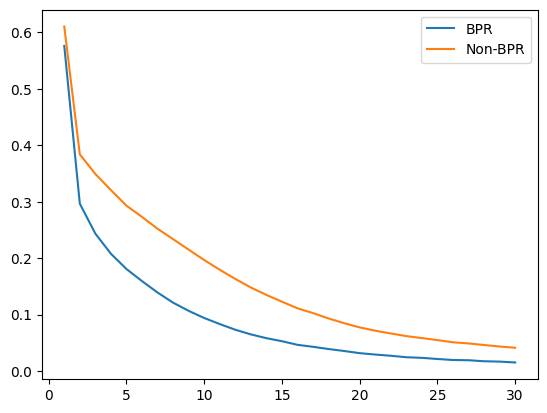

In [ ]:
import matplotlib.pyplot as plt

epochs = [i+1 for i in range(config.epochs)]
plt.plot(epochs, bpr_model_loss_list, label = 'BPR')
plt.plot(epochs, non_bpr_model_loss_list, label = 'Non-BPR')
plt.legend()
plt.show()